<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/pytorch/GoogLeNetv1_CIFAR100_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoogLeNet, CIFAR100

In [18]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

# Import and Config

In [41]:
import os
from pprint import pprint
import argparse

import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns

import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = range(10) # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 32
cfg.INPUT_WIDTH = 32
cfg.INPUT_CHANNEL = 3
cfg.INPUT_MODE = 'RGB' #RGB, GRAY, CLASS_LABEL, EDGE

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)


# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'GoogLeNetv1'
cfg.TRAIN.MODEL_SAVE_PATH = 'models/' + cfg.PREFIX + '_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 10_000
cfg.TRAIN.ITERATION = 10_000
#cfg.TRAIN.EPOCH = 2
cfg.TRAIN.MINIBATCH = 256
cfg.TRAIN.OPTIMIZER = torch.optim.SGD
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.001, 'momentum' : 0.9} #{'lr' : 0.02, 'betas' : (0.5, 0.9)}
cfg.TRAIN.LOSS_FUNCTION = loss_fn = torch.nn.CrossEntropyLoss()

cfg.TRAIN.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False
cfg.TRAIN.DATA_VERTICAL_FLIP = False
cfg.TRAIN.DATA_ROTATION = False

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.csv'

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_PATH = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/test/images/
cfg.TEST.MINIBATCH = 100
cfg.TEST.ITERATION = 2
cfg.TEST.MAX_NUM = 100
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': range(0, 10),
 'CLASS_NUM': 10,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'GPU': True,
 'INPUT_CHANNEL': 3,
 'INPUT_HEIGHT': 32,
 'INPUT_MODE': 'RGB',
 'INPUT_WIDTH': 32,
 'PREFIX': 'GoogLeNetv1',
 'TEST': {'DATA_PATH': './data/',
          'ITERATION': 2,
          'MAX_NUM': 100,
          'MINIBATCH': 100,
          'MODEL_PATH': 'models/GoogLeNetv1_final.pt',
          'RESULT_IMAGE_PATH': 'result/GoogLeNetv1_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': False,
           'DATA_PATH': './data/',
           'DATA_ROTATION': False,
           'DATA_VERTICAL_FLIP': False,
           'DISPAY_ITERATION_INTERVAL': 50,
           'ITERATION': 10000,
           'LEARNING_PARAMS': {'lr': 0.001, 'momentum': 0.9},
           'LEARNING_PROCESS_RESULT_IMAGE_PATH': 'result/GoogLeNetv1_result_{}.jpg',
           'LEARNING_PROCESS_RESULT_INTERVAL': 500,
           'LEARNING_PROCESS_RESULT_LOSS_PATH': 'result/G

# Model

In [0]:
class InceptionModule(torch.nn.Module):
    def __init__(self, in_f, f_1, f_2_1, f_2_2, f_3_1, f_3_2, f_4_2):
        super(InceptionModule, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_f, f_1, kernel_size=1, padding=0, stride=1)
        
        self.conv2_1 = torch.nn.Conv2d(in_f, f_2_1, kernel_size=1, padding=0, stride=1)
        self.conv2_2 = torch.nn.Conv2d(f_2_1, f_2_2, kernel_size=3, padding=1, stride=1)
        
        self.conv3_1 = torch.nn.Conv2d(in_f, f_3_1, kernel_size=1, padding=0, stride=1)
        self.conv3_2 = torch.nn.Conv2d(f_3_1, f_3_2, kernel_size=5, padding=2, stride=1)

        self.conv4_2 = torch.nn.Conv2d(in_f, f_4_2, kernel_size=1, padding=0, stride=1)

        
    def forward(self, x):
        x1 = torch.nn.ReLU()(self.conv1(x))
        
        x2 = torch.nn.ReLU()(self.conv2_1(x))
        x2 = torch.nn.ReLU()(self.conv2_2(x2))

        x3 = torch.nn.ReLU()(self.conv3_1(x))
        x3 = torch.nn.ReLU()(self.conv3_2(x3))

        x4 = F.max_pool2d(x, 3, padding=1, stride=1)
        x4 = torch.nn.ReLU()(self.conv4_2(x4))
        x = torch.cat([x1, x2, x3, x4], dim=1)
        return x


class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.reshape(x.size()[0], -1)    

class GoogLeNetv1(torch.nn.Module):
    def __init__(self):
        super(GoogLeNetv1, self).__init__()

        self.stem = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2), # for arbitrary input size
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=0),
            torch.nn.Conv2d(64, 64, kernel_size=1, padding=0, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 192, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=0),
            InceptionModule(192, 64, 96, 128, 16, 32, 32), # inception 3a
            InceptionModule(256, 128, 128, 192, 32, 96, 64), # inception 3b
            torch.nn.MaxPool2d(2, stride=2, padding=0),
            InceptionModule(480, 192, 96, 208, 16, 48, 64) # inception 4a
        )

        self.aux_module1 = torch.nn.Sequential(
            torch.nn.AvgPool2d(5, stride=1, padding=2),
            torch.nn.Conv2d(512, 128, kernel_size=1, padding=0, stride=1),
            torch.nn.ReLU(),
            Flatten(),
            torch.nn.Linear(128 * (cfg.INPUT_HEIGHT // 16) * (cfg.INPUT_WIDTH // 16), 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.7),
            torch.nn.Linear(1024, cfg.CLASS_NUM)
        )

        self.inception4 = torch.nn.Sequential(
            InceptionModule(512, 160, 112, 224, 24, 64, 64), # inception 4b
            InceptionModule(512, 128, 128, 256, 24, 64, 64), # inception 4c
            InceptionModule(512, 112, 144, 288, 32, 64, 64), # inception 4d
        )

        self.aux_module2 = torch.nn.Sequential(
            torch.nn.AvgPool2d(5, stride=1, padding=2),
            torch.nn.Conv2d(528, 128, kernel_size=1, padding=0, stride=1),
            torch.nn.ReLU(),
            Flatten(),
            torch.nn.Linear(128 * (cfg.INPUT_HEIGHT // 16) * (cfg.INPUT_WIDTH // 16), 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.7),
            torch.nn.Linear(1024, cfg.CLASS_NUM)
        )

        self.top = torch.nn.Sequential(
            InceptionModule(528, 256, 160, 320, 32, 128, 128), # inception 4e
            torch.nn.MaxPool2d(3, stride=2, padding=1),
            InceptionModule(832, 256, 160, 320, 32, 128, 128), # inception 5a
            InceptionModule(832, 384, 192, 384, 48, 128, 128), # inception 5b
            torch.nn.AdaptiveAvgPool2d([1, 1]),
            Flatten(),
            torch.nn.Linear((384 + 384 + 128 + 128) * (cfg.INPUT_HEIGHT // 32) * (cfg.INPUT_WIDTH // 32), cfg.CLASS_NUM)
        )
        
    def forward(self, x):
        x = self.stem(x)
        x_aux1 = self.aux_module1(x)
        x = self.inception4(x)
        x_aux2 = self.aux_module2(x)
        x = self.top(x)
        return x, x_aux1, x_aux2

# Utility

In [0]:
class BatchGenerator():
    def __init__(self, data_size, batch_size, shuffle=True):
        self.data_size = data_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mbi = 0 # index for iteration
        self.inds = np.arange(data_size)
        if shuffle:
            np.random.shuffle(self.inds)

    def __call__(self):
        if self.mbi + self.batch_size >= self.data_size:
            inds = self.inds[self.mbi:]
            if self.shuffle:
                np.random.shuffle(self.inds)
            inds = np.hstack((inds, self.inds[ : (self.batch_size - (self.data_size - self.mbi))]))
            self.mbi = self.batch_size - (self.data_size - self.mbi)
        else:
            inds = self.inds[self.mbi : self.mbi + self.batch_size]
            self.mbi += self.batch_size
        return inds

# Train

In [42]:
def train():
    # model
    model = GoogLeNetv1().to(cfg.DEVICE)
    model.train()
    
    summary(model, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)

    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    ds = torchvision.datasets.CIFAR10(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).permute(0, 3, 1, 2).to(cfg.DEVICE)
    Xs_data = Xs_data / 127.5 - 1
    ts_data = torch.tensor(ds.targets, dtype=torch.long).to(cfg.DEVICE)
    data_num = len(Xs_data)
    #train_ts = np.identity(cfg.CLASS_NUM)[trainset.targets] # one hot

    # training
    batch_gen = BatchGenerator(data_num, cfg.TRAIN.MINIBATCH)

    list_iter = []
    list_loss= []
    list_accuracy = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        # sample X and t
        mb_inds = batch_gen()
        #Xs = torch.tensor(preprocess(Xs_data[mb_inds], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
        Xs = Xs_data[mb_inds]
        ts = ts_data[mb_inds]

        # forward and update
        opt.zero_grad()

        ys, y_aux1, y_aux2 = model(Xs)

        loss_ = cfg.TRAIN.LOSS_FUNCTION(ys, ts)
        loss_aux1 = cfg.TRAIN.LOSS_FUNCTION(y_aux1, ts)
        loss_aux2 = cfg.TRAIN.LOSS_FUNCTION(y_aux2, ts)
        loss = loss_ + loss_aux1 + loss_aux2
        loss.backward()
        opt.step()
    
        preds = ys.argmax(dim=1, keepdim=True).reshape(-1)
        accuracy = (preds == ts).sum() / float(cfg.TRAIN.MINIBATCH)

        _loss = loss.item()
        _accuracy = accuracy.item()

        progres_bar += '|'

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
                list_accuracy.append(_accuracy)

        print('\r' + 'Loss:{:.4f}, Accu:{:.4f} '.format(_loss, _accuracy) + progres_bar, end='')

                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f}, Accu:{:.4f}'.format(i + 1, _loss, _accuracy))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model.state_dict(), save_path)
            print('save >> {}'.format(save_path))


    save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
    torch.save(model.state_dict(), save_path)
    print('final paramters were saved to >> {}'.format(save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss, 'accuracy' : list_accuracy})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
              ReLU-2           [-1, 64, 16, 16]               0
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]           4,160
              ReLU-5             [-1, 64, 8, 8]               0
            Conv2d-6            [-1, 192, 8, 8]         110,784
              ReLU-7            [-1, 192, 8, 8]               0
         MaxPool2d-8            [-1, 192, 4, 4]               0
            Conv2d-9             [-1, 64, 4, 4]          12,352
           Conv2d-10             [-1, 96, 4, 4]          18,528
           Conv2d-11            [-1, 128, 4, 4]         110,720
           Conv2d-12             [-1, 16, 4, 4]           3,088
           Conv2d-13             [-1, 32, 4, 4]          12,832
           Conv2d-14             [-1, 3

# plot Loss, Accuracy

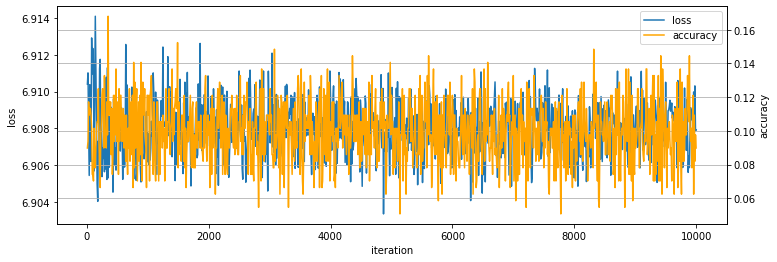

In [43]:
def plot_process():
    df = pd.read_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax2 = ax.twinx()
    lns1 = ax.plot(df['iteration'], df['loss'], label='loss')
    lns2 = ax2.plot(df['iteration'], df['accuracy'], color='orange', label='accuracy')

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    ax.set_ylabel('loss')
    ax.set_xlabel('iteration')
    ax2.set_ylabel('accuracy')
    plt.grid()
    plt.show()

plot_process()

# Test

In [44]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    model = GoogLeNetv1().to(cfg.DEVICE)
    model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    np.random.seed(0)

    ds = torchvision.datasets.CIFAR100(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).permute(0, 3, 1, 2).to(cfg.DEVICE)
    Xs_data = Xs_data / 127.5 - 1
    ts_data = np.array(ds.targets)
    data_num = len(Xs_data)
    
    table = np.zeros([cfg.CLASS_NUM, cfg.CLASS_NUM])

    inds = np.arange(data_num)

    with torch.no_grad():
        for i in range(0, data_num, cfg.TEST.MINIBATCH):
            # get batch index
            mb_inds = inds[i : min(i + cfg.TEST.MINIBATCH, data_num)]
            Xs = Xs_data[mb_inds]
            ts = ts_data[mb_inds]

            # forward
            ys = model(Xs).detach().cpu().numpy()
            ys = ys.argmax(axis=1)
            
            for t, y in zip(ts, ys):
                table[t, y] += 1

            print('\r{} / {}'.format(mb_inds[-1] + 1, data_num), end='')

    accuracy = table[np.arange(cfg.CLASS_NUM), np.arange(cfg.CLASS_NUM)].sum() / table.sum()
    print('\naccuracy =', accuracy)
    print('ts / pred table')
    pprint(table)
    sns.heatmap(table)

test()

--------------------
test function
--------------------
Files already downloaded and verified


AttributeError: ignored